In [1]:
from os.path import join

import matplotlib.pyplot as plt
%matplotlib inline

import gensim
import numpy as np
import scipy as sp

from sklearn.datasets import fetch_20newsgroups


%run ../src/load_data_utils.py
%run ../src/glove_2_word2vec.py

call 
    
    make prepare_embeddings in_file_name=glove.6B.100d.txt out_file_name=glove.6B.100d.w2v
    
To setup word vectors (you can also change 100 to 50, 200 or 300)

In [2]:
__, DATA_DIR = get_env_vars(True)
VECTORS_DIR = join(DATA_DIR, 'glove.6B')
FILENAME_PREFIX = 'glove.6B.100d'
VECTORS_FILENAME_DIR = join(VECTORS_DIR, FILENAME_PREFIX + '.txt')

newsgroups_train = fetch_20newsgroups()
newsgroups_test = fetch_20newsgroups(subset='test')

model = gensim.models.KeyedVectors.load(str(join(VECTORS_DIR, FILENAME_PREFIX + '.w2v')))

## Checking words similarity

$king + woman - man \approx queen$ example

In [3]:
model.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.7698541283607483),
 ('monarch', 0.6843380928039551),
 ('throne', 0.6755735874176025),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534753799438),
 ('prince', 0.6517034769058228),
 ('elizabeth', 0.6464517712593079),
 ('mother', 0.6311717629432678),
 ('emperor', 0.6106470823287964),
 ('wife', 0.6098655462265015)]

## Preprocessing text

This will make retrieving weights for incorporating tf-idf to aggregated word embeddings easier.

In [4]:
from collections import OrderedDict
import re

TOKENIZING_PATTERN = '(?u)\\b\\w\\w+\\b'

def preprocess_texts(sentences_list):
  return (list(
    map(
      lambda sentence: 
        ' '.join(OrderedDict.fromkeys(re.findall(TOKENIZING_PATTERN, sentence)))
          .lower(),
      sentences_list)))

X_train_text = preprocess_texts(newsgroups_train['data'])
X_test_text = preprocess_texts(newsgroups_test['data'])

## Bag of Words encoding

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(token_pattern=TOKENIZING_PATTERN, min_df=2, max_df=0.025)

X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

X_train.shape

(11314, 55564)

In [6]:
y_train = newsgroups_train['target']
y_test = newsgroups_test['target']

In [7]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_iter=50)
%time X_reduced = tsvd.fit_transform(X_train)

CPU times: user 7.12 s, sys: 13.5 s, total: 20.7 s
Wall time: 5.72 s


## Truncated SVD plot

Truncated SVD of rank $k$ is algorithm that computes $k$ principal components of a matrix, like PCA but iteratively.

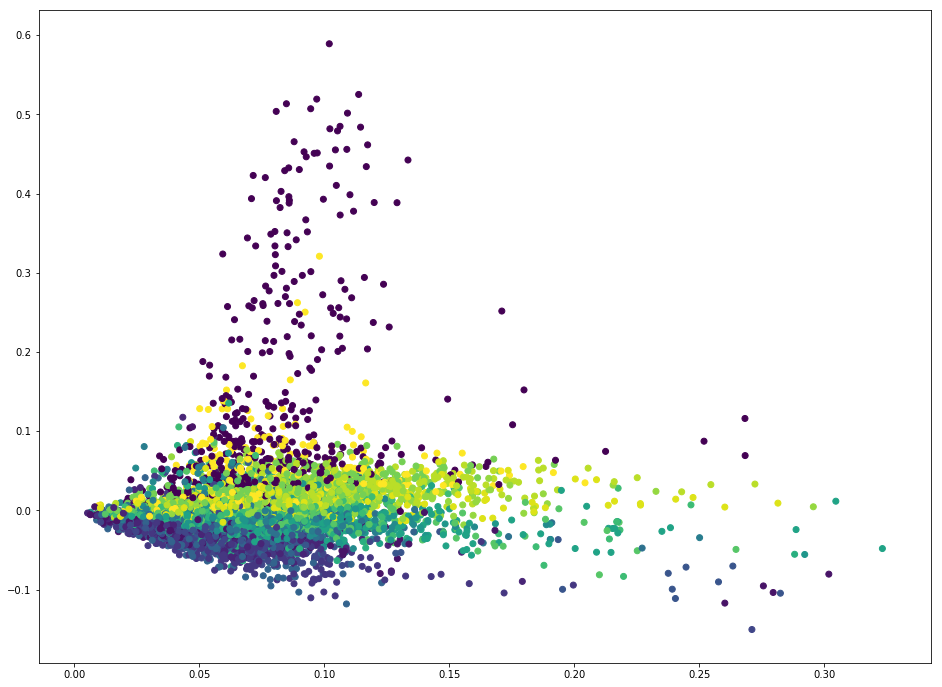

In [8]:
plt.figure(figsize=(16, 12))

plt.scatter(*X_reduced.T, c=y_train)
plt.show()

## Aggregating word embeddings

We'll take two aggregation strategies: the first would be to just average word vectors over the words in a sentence that happen to be in model vocabulary.

The second one also incorporates weights from tf-idf model.

In [9]:
def encode_sentence(glove_model, sent, weights=None):
  if weights is None:
    normalizing_factor = len(sent)
    word_vectors = (glove_model[w] for w in sent if glove_model.vocab.get(w))
  else:
    normalizing_factor = len([w for w in sent if glove_model.vocab.get(w)])
    word_vectors = (glove_model[w] * weights[i] for (i, w) in enumerate(sent) if glove_model.vocab.get(w))
  return sum(word_vectors) / normalizing_factor

In [10]:
%time X_glove_train = np.array([encode_sentence(model, s.split()) for s in X_train_text])
%time X_glove_test = np.array([encode_sentence(model, s.split()) for s in X_test_text])

CPU times: user 6.62 s, sys: 0 ns, total: 6.62 s
Wall time: 6.63 s
CPU times: user 4.31 s, sys: 0 ns, total: 4.31 s
Wall time: 4.31 s


In [ ]:
from operator import itemgetter
from itertools import groupby

def encode_sentences(X_tfidf, tfidf):
  def get_nonzeros(v):
    try:
      nz = v[v.nonzero()].tolist()
    except AttributeError:
      print(v[v.nonzero()])
    else:
      return v[v.nonzero()].tolist()[0]
  retrieved_sentences = tfidf.inverse_transform(X_tfidf)
  return (np.array(
    [
      encode_sentence(
        model, 
        retrieved_sentences[i],
        weights=get_nonzeros(X_tfidf[i, :]))
      for i in range(X_tfidf.shape[0])]))


In [ ]:
%time X_glove_weighted_train = encode_sentences(X_train, tfidf)
%time X_glove_weighted_test = encode_sentences(X_test, tfidf)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

%time X_glove_weighted_train_pca = pca.fit_transform(X_glove_weighted_train)
%time X_glove_train_pca = pca.fit_transform(X_glove_train)

## Aggregated word embeddings plot

In [ ]:
plt.figure(figsize=(16, 12))

plt.title('Mean averaged word embeddings')
plt.scatter(*X_glove_train_pca.T, c=y_train)
plt.show()

plt.figure(figsize=(16, 12))

plt.title('Tfidf weight-averaged word embeddings')
plt.scatter(*X_glove_weighted_train_pca.T, c=y_train)
plt.show()

# Classification

We'll use SGDClassifier which uses (linear) SVMs internally.

In [ ]:
from sklearn.metrics import f1_score 
from sklearn.linear_model import SGDClassifier 

sparse_lreg = SGDClassifier(n_iter=25, alpha=0.0001)

%time sparse_lreg.fit(X_train, y_train)

Accuracy on tfidf data

In [ ]:
print('accuracy:', round(sparse_lreg.score(X_test, y_test), 3))
print('f1:', round(f1_score(y_test, sparse_lreg.predict(X_test), average='weighted'), 3))

In [ ]:
from sklearn.preprocessing import StandardScaler

dense_lreg = SGDClassifier(n_iter=50, alpha=0.00005)

sscaler = StandardScaler()

X_glove_normalized_train = sscaler.fit_transform(X_glove_train)

%time dense_lreg.fit(X_glove_train, y_train)#, classes=np.unique(y_train))

Accuracy on means of embedded words

In [ ]:
print('accuracy:', round(dense_lreg.score(X_glove_test, y_test), 3))
print('f1:', round(f1_score(y_test, dense_lreg.predict(X_glove_test), average='weighted'), 3))

In [ ]:
dense_lreg = SGDClassifier(n_iter=50, alpha=0.00001)

%time dense_lreg.fit(X_glove_weighted_train, y_train)#, classes=np.unique(y_train))

Accuracy on weighted embedded words

In [ ]:
print('accuracy:', round(dense_lreg.score(X_glove_weighted_test, y_test), 3))
print('f1:', round(f1_score(y_test, dense_lreg.predict(X_glove_weighted_test), average='weighted'), 3))

As we can see, there is radical drop in performance. The next couple of examples can illustrate why.

In [ ]:
n = 5
no_closest=5

text_encodings = [X_glove_train[i, :] for i in range(n)]
text_encodings_weighted = [X_glove_weighted_train[i, :] for i in range(n)]

Closest $10$ words to mean-aggregated texts

In [ ]:
model.most_similar([text_encodings[0]], topn=5)

In [ ]:
model.most_similar([text_encodings[1]], topn=5)

In [ ]:
model.most_similar([text_encodings[2]], topn=5)

Closest words to mean-aggregated texts

In [ ]:
model.most_similar([text_encodings_weighted[0]], topn=5)

In [ ]:
model.most_similar([text_encodings_weighted[1]], topn=5)

In [ ]:
model.most_similar([text_encodings_weighted[2]], topn=5)

In [ ]:
X_train_text[0], y_train[0], [(w, w in model.vocab) for w in tfidf.inverse_transform(X_train[0, :])[0]]